In [1]:
#Motivation: https://github.com/rslim087a/PyTorch-for-Deep-Learning-and-Computer-Vision-Course-All-Codes-
import torch
import numpy as np
from torch import nn
from time import time
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models

In [2]:
!cd /kaggle/working
!git clone https://github.com/jaddoescad/ants-bees-dataset.git

Cloning into 'ants-bees-dataset'...
remote: Enumerating objects: 408, done.
remote: Total 408 (delta 0), reused 0 (delta 0), pack-reused 408 (from 1)
Receiving objects: 100% (408/408), 45.03 MiB | 47.54 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [3]:
!pip install torch_xla

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 MB 10.9 MB/s eta 0:00:00


In [4]:
# Detect if a TPU is available
#import torch_xla
#import torch_xla.core.xla_model as xm
#device = xm.xla_device() if xm.xla_device() is not None else 'cpu'
#print(device)

In [5]:
# Detect if a GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [6]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, ), (0.5, ))
                               ])

transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))
                               ])

#git clone https://github.com/jaddoescad/ants_and_bees.git
training_dataset = datasets.ImageFolder('/kaggle/working/ants-bees-dataset/train', transform=transform_train)
validation_dataset = datasets.ImageFolder('/kaggle/working/ants-bees-dataset/val', transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=20, shuffle=False)

In [7]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

In [8]:
classes = ('ants', 'bees')

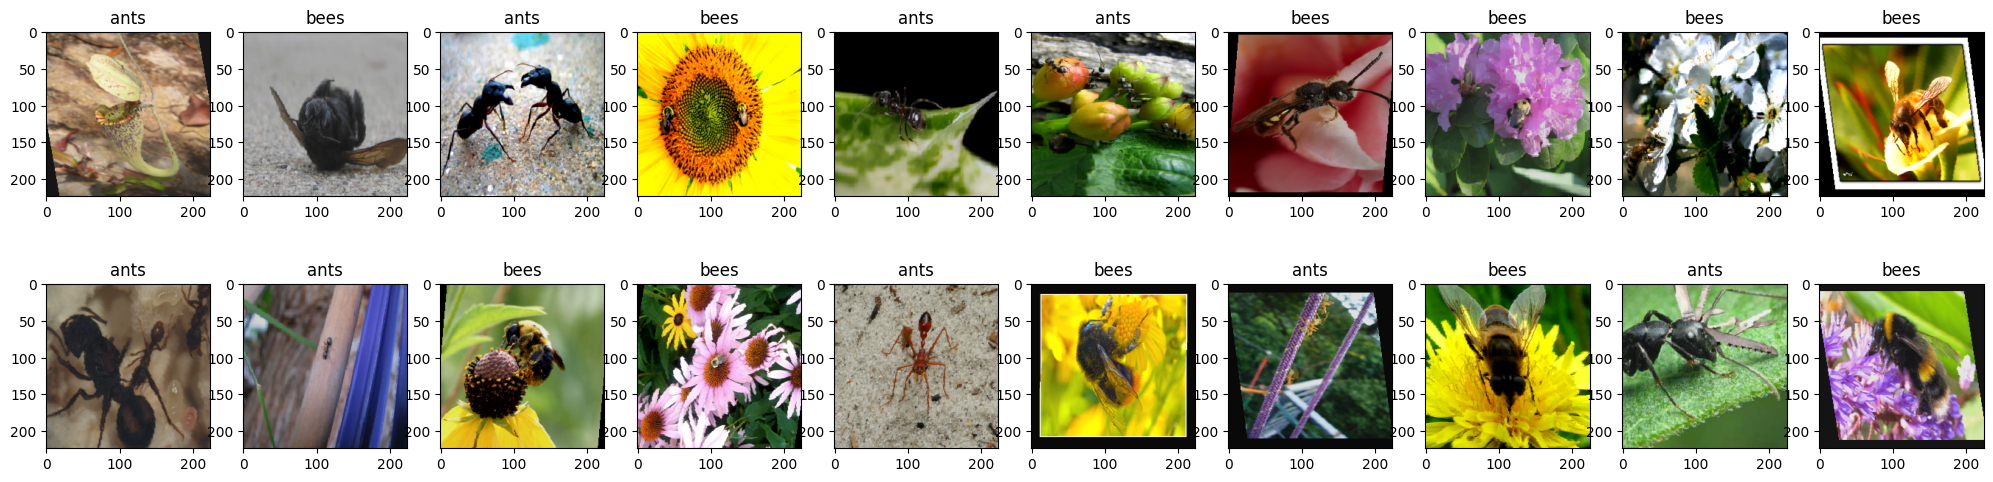

In [9]:
dataiter = iter(training_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 6))

for idx in range(20):
    ax = fig.add_subplot(2, 10, idx + 1)
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [10]:
model = models.alexnet(pretrained=True)
model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 183MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
for param in model.features.parameters():
    param.requires_grad = False

In [12]:
#in_features = model.classifier[6].in_features
#last_layer = nn.Linear(in_features, len(classes))
#model.classifier[6] = last_layer
model.classifier[6].out_features = len(classes)
model = model.to(device)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [14]:
epochs = 15
running_loss_history = []
running_correct_history = []
val_running_loss_history = []
val_running_correct_history = []

for epoch in range(epochs):
    
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    start_time = time()

    for inputs, labels in training_loader:
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #xm.optimizer_step(optimizer)
        
        _, preds = torch.max(outputs, 1)
        preds = preds.detach()
        preds = preds.cpu()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_outputs = model(val_inputs.to(device))
                val_loss = criterion(val_outputs, val_labels.to(device))
                
                _, val_preds = torch.max(val_outputs, 1)
                val_preds = val_preds.detach()
                val_preds = val_preds.cpu()
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
        
        epoch_loss = running_loss / len(training_loader.dataset)
        epoch_acc = running_corrects.float() / len(training_loader.dataset)
        val_epoch_loss = val_running_loss / len(validation_loader.dataset)
        val_epoch_acc = val_running_corrects.float() / len(validation_loader.dataset)

        running_loss_history.append(epoch_loss)
        running_correct_history.append(epoch_acc)
        val_running_loss_history.append(val_epoch_loss)
        val_running_correct_history.append(val_epoch_acc)
        end_time = time()

        print("epoch: ", epoch + 1)
        print("time: {:.2f} seconds".format(end_time - start_time))
        print("training loss: {:.4f}, training accuracy: {:.4f}".format(epoch_loss, epoch_acc.item()))
        print("validation loss: {:.4f}, validation accuracy: {:.4f}".format(val_epoch_loss, val_epoch_acc.item()))

epoch:  1
time: 4.18 seconds
training loss: 0.2043, training accuracy: 0.4180
validation loss: 0.0526, validation accuracy: 0.7582
epoch:  2
time: 3.14 seconds
training loss: 0.0246, training accuracy: 0.8402
validation loss: 0.0324, validation accuracy: 0.8693
epoch:  3
time: 3.12 seconds
training loss: 0.0155, training accuracy: 0.8607
validation loss: 0.0334, validation accuracy: 0.8954
epoch:  4
time: 3.26 seconds
training loss: 0.0138, training accuracy: 0.9180
validation loss: 0.0336, validation accuracy: 0.8235
epoch:  5
time: 3.74 seconds
training loss: 0.0085, training accuracy: 0.9221
validation loss: 0.0288, validation accuracy: 0.8497
epoch:  6
time: 3.13 seconds
training loss: 0.0056, training accuracy: 0.9467
validation loss: 0.0266, validation accuracy: 0.8693
epoch:  7
time: 3.13 seconds
training loss: 0.0058, training accuracy: 0.9672
validation loss: 0.0283, validation accuracy: 0.8627
epoch:  8
time: 3.06 seconds
training loss: 0.0044, training accuracy: 0.9754
valid

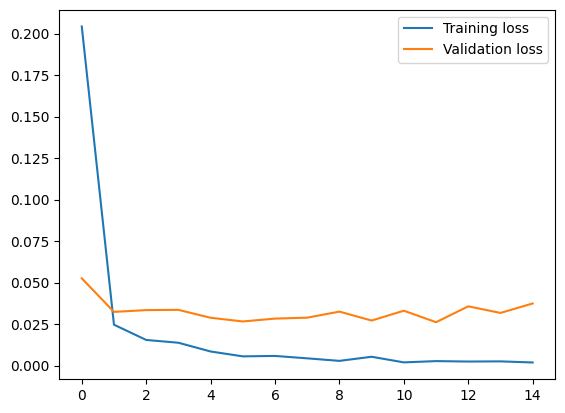

In [15]:
plt.plot(running_loss_history, label='Training loss')
plt.plot(val_running_loss_history, label='Validation loss')
plt.legend()

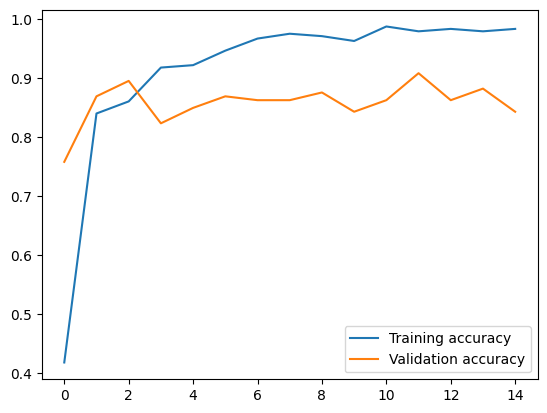

In [16]:
plt.plot(running_correct_history, label='Training accuracy')
plt.plot(val_running_correct_history, label='Validation accuracy')
plt.legend()

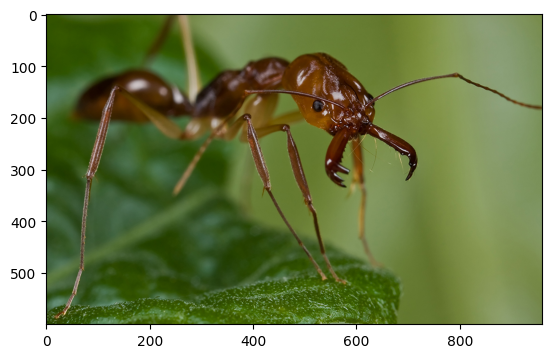

In [17]:
import requests
from PIL import Image

headers = {'User-Agent' : 'Mozilla/5.0 ...' }
url = 'http://s3.amazonaws.com/lab-notes-media/blog/wp-content/uploads/2017/05/top6-weirdants1.jpg'
response = requests.get(url, stream = True, headers = headers)
img = Image.open(response.raw)
plt.imshow(img)

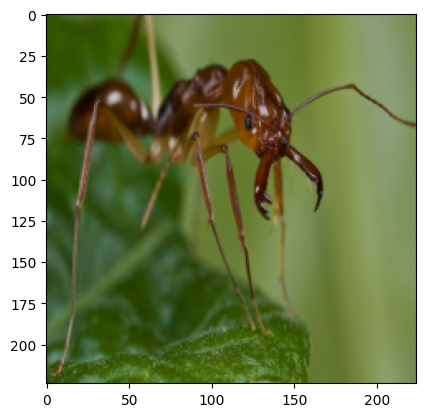

In [18]:
import PIL.ImageOps
img = transform(img) 
plt.imshow(im_convert(img))

In [19]:
print(img.shape)
img = img.unsqueeze(0)
print(img.shape)
output = model(img.to(device))
_, pred = torch.max(output, 1)
print(classes[pred.item()])

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
ants


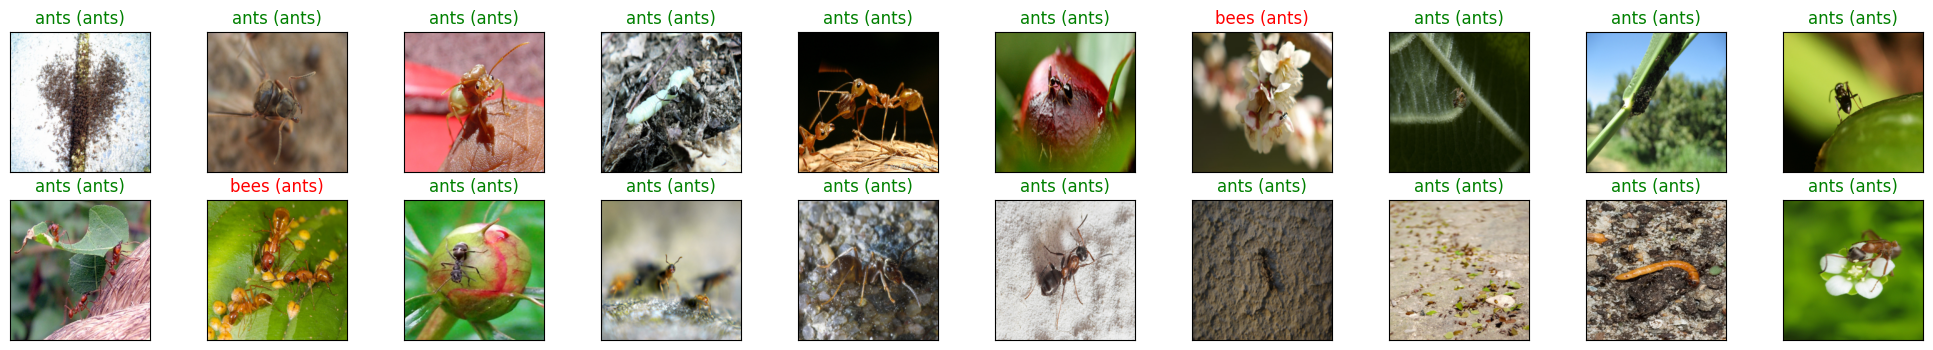

In [20]:
dataiter = iter(validation_loader)
images_, labels = next(dataiter)
output = model(images_.to(device))
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images_[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))